<a href="https://colab.research.google.com/github/linusms/Hands-on/blob/main/chapter_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
  !sudo apt-get install -y fonts-nanum
  !sudo fc-cache -fv
  !rm ~/.cache/matplotlib -rf

  # 상단의 [런타임 - 런타임 다시 시작] 을 클릭하여 런타임을 재시작합니다.

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 0s (19.7 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

In [ ]:
from sklearn.datasets import fetch_openml

mnist=fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [ ]:
X,y=mnist['data'], mnist['target']
X.shape

(70000, 784)

In [ ]:
y.shape

(70000,)

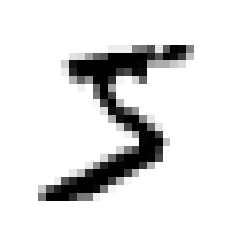

5


In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# 70000개의 이미지에 각각 28*28=784개의 픽셀 존재. 각 픽셀마다 픽셀 강도(0~255)를 값으로 가짐
# 샘플의 특성 벡터들, 1*784 배열을 28*28 배열로 나타냄(reshape)

some_digit=X[0]
some_digit_image=some_digit.reshape(28,28)


plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

# 해당 샘플의 레이블 확인. 유추했던 5와 같음
# 레이블은 문자열. 이를 정수로 변환하는 게 머신러닝 알고리즘에 도움
print(y[0])
y=y.astype(np.uint8)

In [ ]:
X_train, X_test, y_train, y_test=X[:60000], X[60000:], y[:60000], y[60000:]

In [ ]:
# 이진 분류기(5는 True, 다른 숫자는 False 반환)
# y_train_5의 자료형은 배열

y_train_5=(y_train==5)
y_test_5=(y_test==5)

In [ ]:
# 확률적 경사 하강법 분류기 이용. 
# X_train이라는 훈련 데이터와 y_train_5라는 target값 지정
# y_train_5는 훈련 데이터의 레이블이 5일 경우 1(True), 아니면 0(False)을 반환
# 이진 분류기 사용을 위해 레이블을 0 또는 1로 변경

from sklearn.linear_model import SGDClassifier
sgd_clf=SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(random_state=42)

In [ ]:
# 학습된 모델을 토대로 예측하기
# True 값이 나오는 array 반환(타겟 값도 array 자료형이었으므로?)

sgd_clf.predict([some_digit])


array([ True])

In [ ]:
# 참고 : k-겹 교차 검증 수행 코드 구현해보기
# 이는 cross_val_score() 함수와 거의 동일한 기능 수행(분류에서는)

# skfolds는 StratifiedKFold 객체
# skfolds.split은 이 객체를 훈련 데이터와 테스트 데이터로 나누는 메서드
# KFold와는 달리 split 시 레이블도 매개변수로 받아야 함(필수)
# why? 레이블 분포도에 따라 폴드를 나누는 방법이기 때문
# 먼저 

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# 질문: StratifiedKFold는 뷴류기이다. 왜 굳이 split 메소드를 쓰기 위해 이 객체를 지정해야 하는지?
# 어차피 폴드 생성을 위한 것이라면, 그냥 StratifiedKFold라는 함수 내지 메소드를 만들었으면 좋았을텐데..
# 왜 StratifiedKFold를 클래스로 만들었는지 궁금. 폴드 나누기 이외에도 이 객체가 자주 쓰이는가?

skfolds=StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

# StratifiedKFold 객체에 내장된 메소드인 split을 이용해 훈련 세트/테스트 세트가 될 샘플들의 인덱스를 추출 
# 깨알같은 folds와 fold의 차이(즉, 훈련 세트들이 될 폴드'들'과 테스트 세트가 되는 폴드의 차이) 유의
for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf=clone(sgd_clf)
  X_train_folds=X_train[train_index]
  y_train_folds=y_train_5[train_index]
  X_test_fold=X_train[test_index]
  y_test_fold=y_train_5[test_index]

  # clone_clf는 앞서 사용한 SGD 분류기 모델의 복사본 
  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred=clone_clf.predict(X_test_fold)
  n_correct=sum(y_pred==y_test_fold)

  # 정답 개수 / 총 예측값들 개수
  print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [ ]:
# 정확도가 95% 이상

from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [ ]:
from sklearn.base import BaseEstimator

# Never5Classifier라는 클래스 생성. 즉 5를 분류하는 분류기 생성
# 앞서 배웠듯이, BaseEstimator 계승을 통해 get_params, set_params 함수 갖다쓰기

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X),1), dtype=bool)

In [ ]:
# 정확도가 90% 이상. 하지만 데이터의 10%만 숫자 5이기 때문에
# 사실상 의미 없는 정확도. 이는 불균형한 데이터셋(특정 카테고리값이 다른 것보다 월등히 많은 경우) 흔히 발생하는 문제
# 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유

never_5_clf=Never5Classifier()

cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

In [ ]:
# 평가 점수가 아닌, 테스트 폴드에서 얻은 '예측' 반환
# 훈련하는 동안 보지 못한 데이터에 대해 예측한 값 반환
# y_train_pred에는 실제5-예측5, 실제5-예측5아님으로 분류된 예측값들 존재

from sklearn.model_selection import cross_val_predict

y_train_pred=cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [ ]:
# 오차 행렬 생성(오진률 표와 비슷)
# 첫 행은 음성 클래스(5가 아닌 샘플들), 두번째 행은 양성 클래스(5가 아닌 샘플들)
# 첫 열은 음성 판정(5가 아니라고 예측한 예측값의 수), 두번째 열은 양성 판정(5라고 예측)
# 완벽한 분류기는 오답의 가능성이 없으므로 대각행렬이 될 것

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [ ]:
# 앞선 5분류기의 정밀도

from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)


0.8370879772350012

In [ ]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [ ]:
y_scores=sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [ ]:
threshold=0
y_some_digit_pred=(y_scores>threshold)
y_some_digit_pred

array([ True])

In [ ]:
# cross_val_predict 함수에서 결정 점수를 반환받도록 method 지정


y_scores=cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

# 가능한 모든 임계값에서의 정밀도와 재현률을 반환하는 precision_recall_curve 함수 이용

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds=precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, threshold):
  plt.plot(thresholds, precisions[:-1], 'b--', label='정밀도')
  plt.plot(thresholds, recalls[:-1], 'g--', label='재현률')
  plt.legend()
  plt.xlabel('임곗값')

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


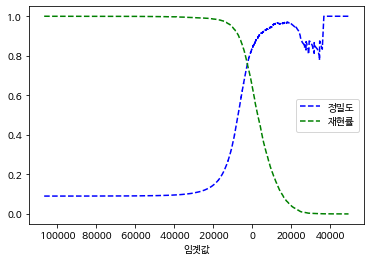

In [ ]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

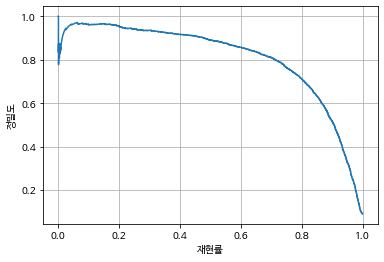

In [ ]:
plt.plot(recalls, precisions)
plt.xlabel('재현률')
plt.ylabel('정밀도')
plt.grid()
plt.show()


In [ ]:
# 정밀도 90%가 되는 첫번째 True 값. 즉 조건이 True가 되는 첫번째 인덱스

threshold_90_precision=thresholds[np.argmax(precisions>=0.90)]

# 정밀도 90%가 되는 분류기
# 내가 원하는 정밀도를 가지는 분류기를 만들 수 있다
# 임계값보다 결정함수 값이 높은 경우만을 True로 반환하는 타겟 값 설정

y_train_pred_90=(y_scores>=threshold_90_precision) 
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr,tpr,linewidth=2, label=label)
  plt.plot([0,1],[0,1],'k--')
  plt.grid()
  plt.xlabel('거짓 양성 비율')
  plt.ylabel('진짜 양성 비율(재현율)')

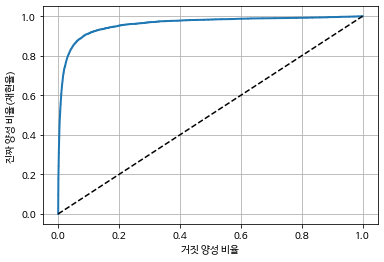

In [ ]:
plot_roc_curve(fpr,tpr)
plt.savefig('ROC 그래프.png')

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [ ]:
# RandomForestClassifier 에는 decision_function() 메서드 대신
# predict_proba() 메서드 존재. 각 클래스(열)에 속할 확률을 샘플(행)마다 보여주는 배열 반환 

from sklearn.ensemble import RandomForestClassifier

forest_clf=RandomForestClassifier(random_state=42)
y_probas_forest=cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

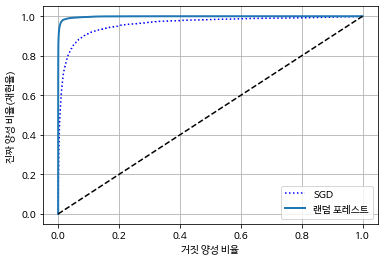

In [ ]:
# 양성 클래스 확률을 점수로 사용

y_scores_forest=y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest=roc_curve(y_train_5, y_scores_forest)


# 그래프를 보면 랜덤 포레스트 분류기가 SGD보다 훨씬 좋은(더 좌상단에 위치한) 것을 볼 수 있음
# 이는 그래프 밑 면적(AUC)가 높다는 뜻
plt.plot(fpr, tpr, "b:", label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, '랜덤 포레스트')
plt.legend(loc='lower right')
plt.show()

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [ ]:
print(y_probas_forest)

[[0.11 0.89]
 [0.99 0.01]
 [0.96 0.04]
 ...
 [0.02 0.98]
 [0.92 0.08]
 [0.94 0.06]]


In [ ]:
# 이진 분류기의 타겟 클래스에 이진 클래스 대신 다중 클래스를 넣으면
# 사이킷런의 알고리즘이 자동으로 OvR 실행 (즉, n*(n-1)/2개의 분류기 생성, 훈련)
# 주의: 60,000개의 훈련 세트에 대해서 실행하면 시간 오래 걸림. 3분 이상

from sklearn.svm import SVC

svm_clf=SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])


array([5], dtype=uint8)

In [ ]:
# 배열에서 6번째 결정함수 값이 가장 큼(즉, 5로 분류한 분류기의 예측 점수가 가장 좋다는 뜻)


some_digit_scores=svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [ ]:
# 5의 가능성이 가장 높다. 가장 높은 클래스를 답으로 선택
# 분류기 svm_clf 객체에 타겟 클래스의 리스트가 저장되어있는 속성 .classes_

print(np.argmax(some_digit_scores))
print(svm_clf.classes_[5])
svm_clf.classes_

5
5


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier

X_train_s=X_train[:1000]
y_train_s=y_train[:1000]
ovr_clf=OneVsRestClassifier(SVC())
ovr_clf.fit(X_train_s, y_train_s)
ovr_clf.predict([some_digit])
print(len(ovr_clf.estimators_))

10


In [ ]:
#SGD분류기 이용한 학습 - 분류기에서 다중 클래스 지원하므로 따로 OvR 적용 필요 X

sgd_clf.fit(X_train_s, y_train_s)
print(sgd_clf.decision_function([some_digit]))

cross_val_score(sgd_clf, X_train_s, y_train_s, cv=3, scoring='accuracy')

[[-6049581.97985829 -6138036.45541781 -3886281.38604606  -604692.42366776
  -6948311.32017537   914498.2913215  -6855666.78647961 -3866146.33271573
  -4016434.08430155 -3209136.89074954]]


array([0.83233533, 0.82882883, 0.79279279])

In [ ]:
# 데이터 표준화 전처리 후 모델을 돌리면 결과가 더 좋다 (왜?)
# 이 코드는 코드 실행 시간이 너무 길어 훈련 세트를 1000개로 줄였으므로 정확도가 훨씬 낮음

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train_s.astype(np.float64))

cross_val_score(sgd_clf, X_train_scaled, y_train_s, cv=3, scoring='accuracy')

array([0.83532934, 0.81681682, 0.82882883])

In [ ]:
# 예측한 값에 대한 오차 행렬


y_train_pred=cross_val_predict(sgd_clf, X_train_scaled, y_train_s, cv=3)
conf_mx=confusion_matrix(y_train_s, y_train_pred)
conf_mx

array([[ 95,   0,   1,   0,   0,   1,   0,   0,   0,   0],
       [  0, 106,   2,   0,   0,   5,   1,   0,   1,   1],
       [  1,   3,  76,   2,   3,   1,   4,   3,   5,   1],
       [  1,   2,   5,  75,   0,   4,   0,   3,   0,   3],
       [  0,   0,   0,   3,  90,   3,   1,   1,   2,   5],
       [  1,   0,   2,   9,   2,  65,   2,   1,   8,   2],
       [  2,   1,   3,   0,   2,   4,  82,   0,   0,   0],
       [  0,   2,   3,   0,   3,   0,   0, 106,   0,   3],
       [  2,   6,   2,   1,   0,   6,   2,   2,  64,   2],
       [  3,   0,   2,   1,   7,   1,   0,  17,   1,  68]])

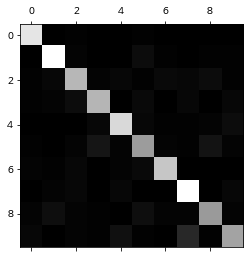

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

# 색깔이 어둡다 :1) 그 클래스에 해당하는 데이터가 부족하다 
# 2) 그 클래스를 다른 클래스만큼 잘 분류하지 못한다 

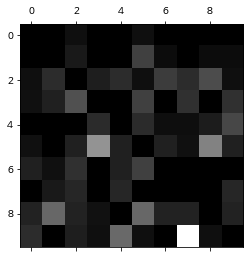

In [ ]:
# 오차 비율을 보아야 하므로
# 오차 행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어 표시
# 이 결과에선, 실제 9(행)가 7(열)로 잘못 분류된 경우가 많다(밝은 색)는 것이 보임 

row_sums=conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx=conf_mx/row_sums

np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

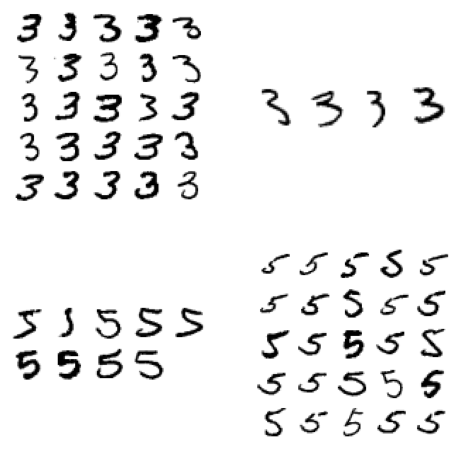

In [ ]:
# 오차행렬의 샘플들 실제 보기
# 시계방향으로 실제3-예측3, 실제3-예측5, 실제5-예측5, 실제5-예측3 이다.
# 이러한 오류가 나타나는 이유: 선형 분류기는 클래스마다 특정 픽셀에 가중치 설정
# 3과 5의 차이는 위쪽 선과 아래쪽 호를 이어주는 작은 직선의 위치
# 즉, 이미지의 위치나 회전 방향이 중요하므로 '정규화'하듯 이미지를 중앙에 위치 시켜주어야 함

cl_a,cl_b=3,5

X_aa=X_train_s[(y_train_s==cl_a)&(y_train_pred==cl_a)]
X_ab=X_train_s[(y_train_s==cl_a)&(y_train_pred==cl_b)]
X_ba=X_train_s[(y_train_s==cl_b)&(y_train_pred==cl_a)]
X_bb=X_train_s[(y_train_s==cl_b)&(y_train_pred==cl_b)]

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = plt.cm.binary, **options)
    plt.axis("off")


plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)  # 이미지 상단 왼편
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)  # 이미지 상단 오른편
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)  # 이미지 하단 왼편
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)  # 이미지 하단 오른편
plt.show()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large